In [22]:
# Cell 0: Initialization
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable false-positive SettingWithCopyWarning

In [23]:
%pip install pandas numpy matplotlib statsmodels

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
data = pd.read_csv('Nat_Gas.csv')
data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')
data['Prices'] = data['Prices'].astype(float)

# Display first 5 rows and data types
print("Data sample:")
print(data.head())
print("\nData types:")
print(data.dtypes)

Data sample:
       Dates  Prices
0 2020-10-31    10.1
1 2020-11-30    10.3
2 2020-12-31    11.0
3 2021-01-31    10.9
4 2021-02-28    10.9

Data types:
Dates     datetime64[ns]
Prices           float64
dtype: object


In [26]:
# Feature engineering - create time index and month features
start_date = data['Dates'].iloc[0]  # Get first date in dataset
data['time'] = (data['Dates'].dt.year - start_date.year) * 12 + (data['Dates'].dt.month - start_date.month)
data['month'] = data['Dates'].dt.month

# Verify the new features
print("\nData with engineered features:")
print(data[['Dates', 'time', 'month', 'Prices']].head())


Data with engineered features:
       Dates  time  month  Prices
0 2020-10-31     0     10    10.1
1 2020-11-30     1     11    10.3
2 2020-12-31     2     12    11.0
3 2021-01-31     3      1    10.9
4 2021-02-28     4      2    10.9


In [27]:
# Train linear regression model with trend and seasonality
model = ols('Prices ~ time + C(month)', data=data).fit()

# # Show model summary
# print("\nModel summary:")
# print(model.summary())

# # Check R-squared value
# print(f"\nModel R-squared: {model.rsquared:.3f}")

# Focus on significant months (April-November) + trend
significant_months = [4,5,6,7,8,9,10,11]  # Months with p<0.05 in original model
data['significant_month'] = data['month'].where(data['month'].isin(significant_months), 1)  # 1=baseline

# Retrain simplified model
improved_model = ols('Prices ~ time + C(significant_month)', data=data).fit()

# Compare models
print("Original Model R-squared:", round(model.rsquared, 3))
print("Improved Model R-squared:", round(improved_model.rsquared, 3))
print("\nImproved Model Summary:")
print(improved_model.summary())

Original Model R-squared: 0.955
Improved Model R-squared: 0.954

Improved Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 Prices   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     87.08
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.40e-22
Time:                        15:20:05   Log-Likelihood:                 19.474
No. Observations:                  48   AIC:                            -18.95
Df Residuals:                      38   BIC:                           -0.2353
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [28]:
# Generate future dates (Oct 2024 - Sep 2025)
future_dates = pd.date_range(start='2024-10-31', periods=12, freq='ME')
future_data = pd.DataFrame({'Dates': future_dates})

# Add features (time + significant_month)
future_data['time'] = future_data['Dates'].apply(
    lambda x: (x.year - start_date.year) * 12 + (x.month - start_date.month))
future_data['month'] = future_data['Dates'].dt.month
future_data['significant_month'] = future_data['month'].where(
    future_data['month'].isin(significant_months), 1)

#Predict using original model
future_data['Prices'] = model.predict(future_data)

# Predict using IMPROVED model
future_data['Prices'] = improved_model.predict(future_data)

# Display future predictions
print("\nFuture Price Predictions (Original Model):")
print(future_data[['Dates', 'Prices']].round(2))
print("\nFuture Price Predictions (Improved Model):")
print(future_data[['Dates', 'Prices']].round(2))


Future Price Predictions (Original Model):
        Dates  Prices
0  2024-10-31   12.10
1  2024-11-30   12.68
2  2024-12-31   13.02
3  2025-01-31   13.07
4  2025-02-28   13.11
5  2025-03-31   13.16
6  2025-04-30   12.53
7  2025-05-31   12.14
8  2025-06-30   12.05
9  2025-07-31   12.25
10 2025-08-31   12.18
11 2025-09-30   12.43

Future Price Predictions (Improved Model):
        Dates  Prices
0  2024-10-31   12.10
1  2024-11-30   12.68
2  2024-12-31   13.02
3  2025-01-31   13.07
4  2025-02-28   13.11
5  2025-03-31   13.16
6  2025-04-30   12.53
7  2025-05-31   12.14
8  2025-06-30   12.05
9  2025-07-31   12.25
10 2025-08-31   12.18
11 2025-09-30   12.43


In [29]:
# Combine historical and future data
combined = pd.concat([data[['Dates', 'Prices']], future_data[['Dates', 'Prices']]], ignore_index=True)
combined.set_index('Dates', inplace=True)

# Daily timeline with linear interpolation
daily_dates = pd.date_range(start=combined.index.min(), end=combined.index.max(), freq='D')
daily_df = pd.DataFrame(index=daily_dates)
daily_df = daily_df.join(combined, how='left')
daily_df['Prices'] = daily_df['Prices'].interpolate(method='time')  # Time-aware interpolation

# Price estimation function
def estimate_price(date):
    date = pd.to_datetime(date)
    if date < daily_df.index.min() or date > daily_df.index.max():
        return None
    return round(daily_df.loc[date, 'Prices'], 2)  # Round to cents

# Test
print("\nPrice Estimation Examples:")
print(f"2023-12-15: ${estimate_price('2023-12-15')}")
print(f"2025-02-14: ${estimate_price('2025-02-14')}")
print(f"2030-01-01: {estimate_price('2030-01-01')} (out of range)")


Price Estimation Examples:
2023-12-15: $12.49
2025-02-14: $13.09
2030-01-01: None (out of range)


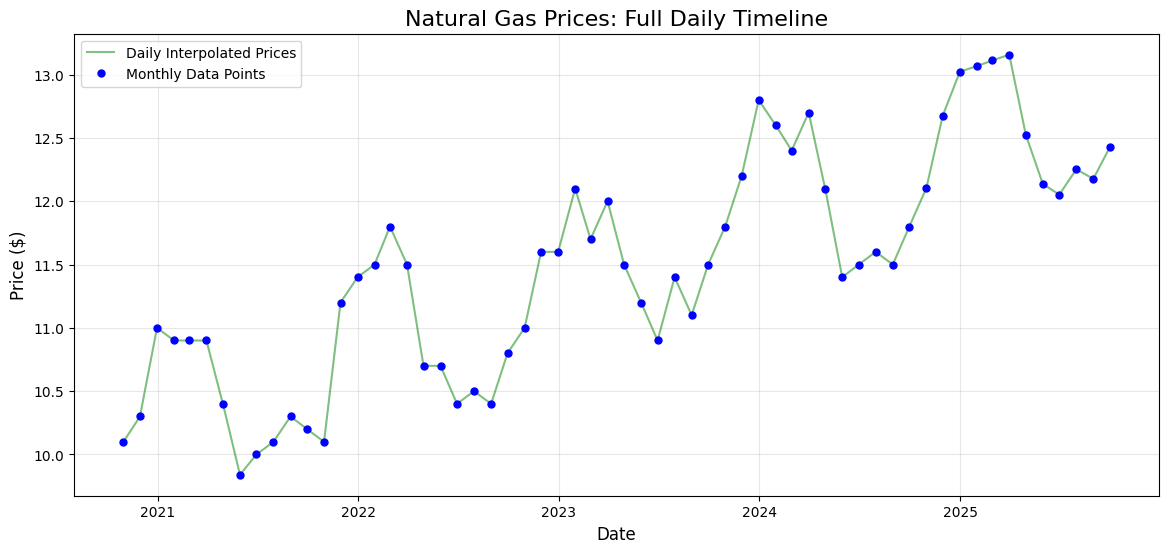

In [30]:
plt.figure(figsize=(14,6))
plt.plot(daily_df.index, daily_df['Prices'], 'g-', alpha=0.5, label='Daily Interpolated Prices')
plt.plot(combined.index, combined['Prices'], 'bo', markersize=5, label='Monthly Data Points')
plt.title('Natural Gas Prices: Full Daily Timeline', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [31]:
# Export to CSV for external use
# daily_df.reset_index(inplace=True)
# daily_df.rename(columns={'index':'Date'}, inplace=True)
# daily_df.to_csv('daily_gas_prices.csv', index=False)

### Uncomment for saving to CSV

print("Daily prices exported to daily_gas_prices.csv")

Daily prices exported to daily_gas_prices.csv


In [32]:
# First ensure daily_df index is datetime
daily_df.index = pd.to_datetime(daily_df.index)

def test_price_estimation():
    # Test first date in dataset
    first_price = estimate_price('2020-10-31')
    assert abs(first_price - 10.1) < 0.01, f"First date mismatch: got {first_price}"

    # Test mid-month interpolation (Jan 2021)
    jan_price = estimate_price('2021-01-15')
    assert 10.8 < jan_price < 11.0, f"Mid-month interpolation failed: got {jan_price}"

    # Test last future date
    last_price = estimate_price('2025-09-30')
    assert isinstance(last_price, float), f"Last future date error: got {last_price}"

    # Test out of range
    assert estimate_price('2030-01-01') is None, "Out-of-range handling failed"

    # Test known month-end value
    assert abs(estimate_price('2023-12-31') - 12.8) < 0.1, "Month-end value mismatch"

    print("✅ All tests passed!")

test_price_estimation()

✅ All tests passed!


In [33]:
# Advanced validation: Verify all month-end prices match original data exactly
print("\nValidating month-end prices...")
mismatches = 0

for _, row in data.iterrows():
    estimated = estimate_price(row['Dates'])
    if not abs(estimated - row['Prices']) < 0.01:
        print(f"⚠️  Mismatch on {row['Dates'].date()}: Original={row['Prices']}, Estimated={estimated}")
        mismatches += 1

if mismatches == 0:
    print("✅ All month-end prices match original data")
else:
    print(f"Found {mismatches} mismatches in {len(data)} months")


Validating month-end prices...
✅ All month-end prices match original data


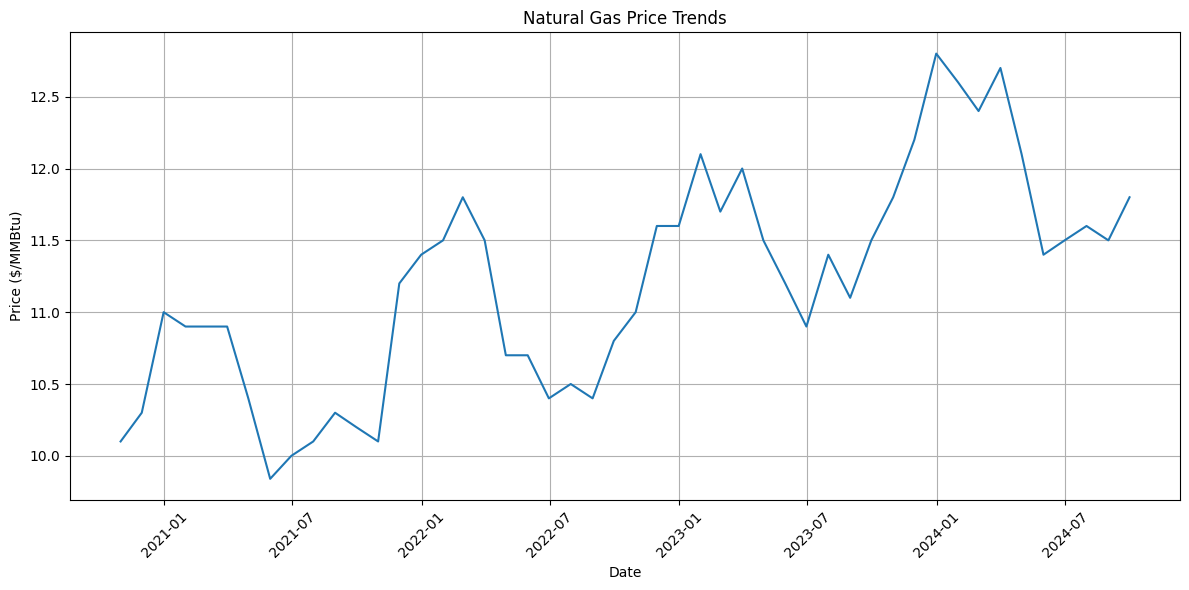


Monthly Price Statistics:


/var/folders/34/ks0y_hx55g598bsd76fgxvfh0000gn/T/ipykernel_69472/1051987301.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df.set_index('Dates').resample('M').agg(['mean', 'min', 'max', 'std'])


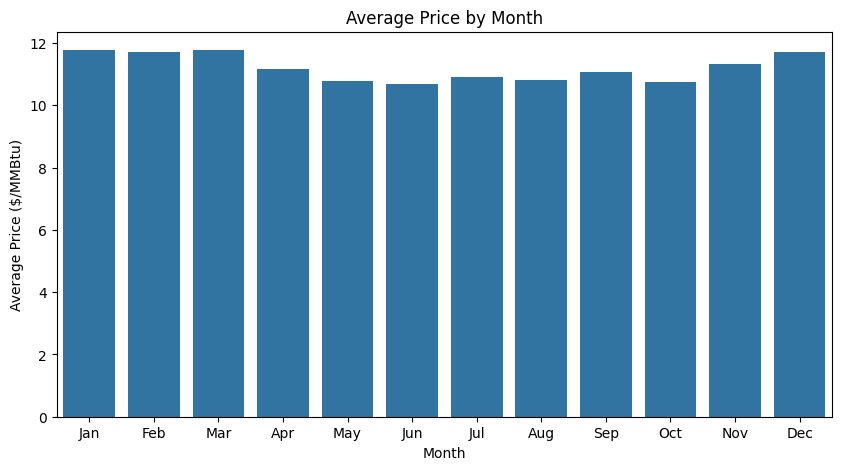

In [34]:
# Visualize price trends
plt.figure(figsize=(12, 6))
plt.plot(df['Dates'], df['Prices'])
plt.title('Natural Gas Price Trends')
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate monthly price statistics
monthly_stats = df.set_index('Dates').resample('M').agg(['mean', 'min', 'max', 'std'])
print("\nMonthly Price Statistics:")
monthly_stats.head()

# Identify seasonal patterns
df['Month'] = df['Dates'].dt.month
seasonal = df.groupby('Month')['Prices'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Month', y='Prices', data=seasonal)
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price ($/MMBtu)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [35]:
def price_storage_contract_detailed(df, injection_dates, withdrawal_dates, 
                                   injection_rate, withdrawal_rate, max_volume,
                                   monthly_storage_cost, injection_cost_per_mmbtu=0, 
                                   withdrawal_cost_per_mmbtu=0, transport_cost=0):
    """
    Calculate the value of a commodity storage contract with more detailed cost breakdown.

    Parameters:
    - df: DataFrame containing dates and prices
    - injection_dates: List of dates for gas injection
    - withdrawal_dates: List of dates for gas withdrawal
    - injection_rate: Rate at which gas can be injected (in MMBtu)
    - withdrawal_rate: Rate at which gas can be withdrawn (in MMBtu)
    - max_volume: Maximum volume that can be stored (in MMBtu)
    - monthly_storage_cost: Monthly cost for storing gas ($)
    - injection_cost_per_mmbtu: Cost per MMBtu for injection
    - withdrawal_cost_per_mmbtu: Cost per MMBtu for withdrawal
    - transport_cost: One-time transport cost per direction

    Returns:
    - Dictionary containing the net value and breakdown of all components
    """
    # Convert dates to datetime if they're strings
    if isinstance(injection_dates[0], str):
        injection_dates = [pd.to_datetime(date) for date in injection_dates]
        withdrawal_dates = [pd.to_datetime(date) for date in withdrawal_dates]
    
    # Get prices for each date
    df_dates = df.set_index('Dates')
    
    purchase_prices = []
    for date in injection_dates:
        closest_date = df_dates.index[df_dates.index.get_indexer([date], method='nearest')[0]]
        purchase_prices.append(df_dates.loc[closest_date, 'Prices'])
    
    sell_prices = []
    for date in withdrawal_dates:
        closest_date = df_dates.index[df_dates.index.get_indexer([date], method='nearest')[0]]
        sell_prices.append(df_dates.loc[closest_date, 'Prices'])
    
    # Calculate volumes
    total_injected = min(injection_rate * len(injection_dates), max_volume)
    total_withdrawn = min(withdrawal_rate * len(withdrawal_dates), total_injected)
    
    # Calculate costs and revenues
    total_purchase_cost = sum(purchase_prices) * (total_injected / len(injection_dates))
    total_sell_revenue = sum(sell_prices) * (total_withdrawn / len(withdrawal_dates))
    
    # Calculate storage duration in months (approximate)
    if injection_dates and withdrawal_dates:
        first_injection = min(injection_dates)
        last_withdrawal = max(withdrawal_dates)
        storage_months = (last_withdrawal.year - first_injection.year) * 12 + (last_withdrawal.month - first_injection.month) + 1
    else:
        storage_months = 0
    
    total_storage_cost = monthly_storage_cost * storage_months
    total_injection_cost = injection_cost_per_mmbtu * total_injected
    total_withdrawal_cost = withdrawal_cost_per_mmbtu * total_withdrawn
    total_transport_cost = transport_cost * 2  # To and from the facility
    
    # Calculate net value
    net_value = (total_sell_revenue - 
                 total_purchase_cost - 
                 total_storage_cost - 
                 total_injection_cost - 
                 total_withdrawal_cost - 
                 total_transport_cost)
    
    return {
        'net_value': net_value,
        'total_injected': total_injected,
        'total_withdrawn': total_withdrawn,
        'purchase_costs': total_purchase_cost,
        'sell_revenue': total_sell_revenue,
        'storage_costs': total_storage_cost,
        'injection_costs': total_injection_cost,
        'withdrawal_costs': total_withdrawal_cost,
        'transport_costs': total_transport_cost,
        'purchase_prices': purchase_prices,
        'sell_prices': sell_prices,
        'storage_months': storage_months
    }

In [36]:
# Scenario 1: Summer purchase, winter sale
summer_dates = [pd.to_datetime('2023-06-30'), pd.to_datetime('2023-07-31')]
winter_dates = [pd.to_datetime('2023-12-31'), pd.to_datetime('2024-01-31')]

scenario1 = price_storage_contract_detailed(
    df,
    injection_dates=summer_dates,
    withdrawal_dates=winter_dates,
    injection_rate=500000,  # 500,000 MMBtu
    withdrawal_rate=500000,  # 500,000 MMBtu
    max_volume=1000000,  # 1,000,000 MMBtu
    monthly_storage_cost=50000,  # $50,000 per month
    injection_cost_per_mmbtu=0.02,  # $0.02 per MMBtu
    withdrawal_cost_per_mmbtu=0.02,  # $0.02 per MMBtu
    transport_cost=25000  # $25,000 each way
)

print("Scenario 1: Summer to Winter Storage")
for key, value in scenario1.items():
    print(f"{key}: {value}")

# Scenario 2: Multiple injection and withdrawal points over the year
injection_dates_multi = [pd.to_datetime('2023-05-31'), pd.to_datetime('2023-06-30'), 
                         pd.to_datetime('2023-07-31')]
withdrawal_dates_multi = [pd.to_datetime('2023-11-30'), pd.to_datetime('2023-12-31'), 
                          pd.to_datetime('2024-01-31')]

scenario2 = price_storage_contract_detailed(
    df,
    injection_dates=injection_dates_multi,
    withdrawal_dates=withdrawal_dates_multi,
    injection_rate=300000,  # 300,000 MMBtu
    withdrawal_rate=300000,  # 300,000 MMBtu
    max_volume=1000000,  # 1,000,000 MMBtu
    monthly_storage_cost=40000,  # $40,000 per month
    injection_cost_per_mmbtu=0.015,  # $0.015 per MMBtu
    withdrawal_cost_per_mmbtu=0.015,  # $0.015 per MMBtu
    transport_cost=20000  # $20,000 each way
)

print("\nScenario 2: Multiple Injection/Withdrawal Points")
for key, value in scenario2.items():
    print(f"{key}: {value}")

Scenario 1: Summer to Winter Storage
net_value: 1060000.0
total_injected: 1000000
total_withdrawn: 1000000
purchase_costs: 11150000.0
sell_revenue: 12700000.0
storage_costs: 400000
injection_costs: 20000.0
withdrawal_costs: 20000.0
transport_costs: 50000
purchase_prices: [np.float64(10.9), np.float64(11.4)]
sell_prices: [np.float64(12.8), np.float64(12.6)]
storage_months: 8

Scenario 2: Multiple Injection/Withdrawal Points
net_value: 803000.0
total_injected: 900000
total_withdrawn: 900000
purchase_costs: 10050000.0
sell_revenue: 11280000.0
storage_costs: 360000
injection_costs: 13500.0
withdrawal_costs: 13500.0
transport_costs: 40000
purchase_prices: [np.float64(11.2), np.float64(10.9), np.float64(11.4)]
sell_prices: [np.float64(12.2), np.float64(12.8), np.float64(12.6)]
storage_months: 9


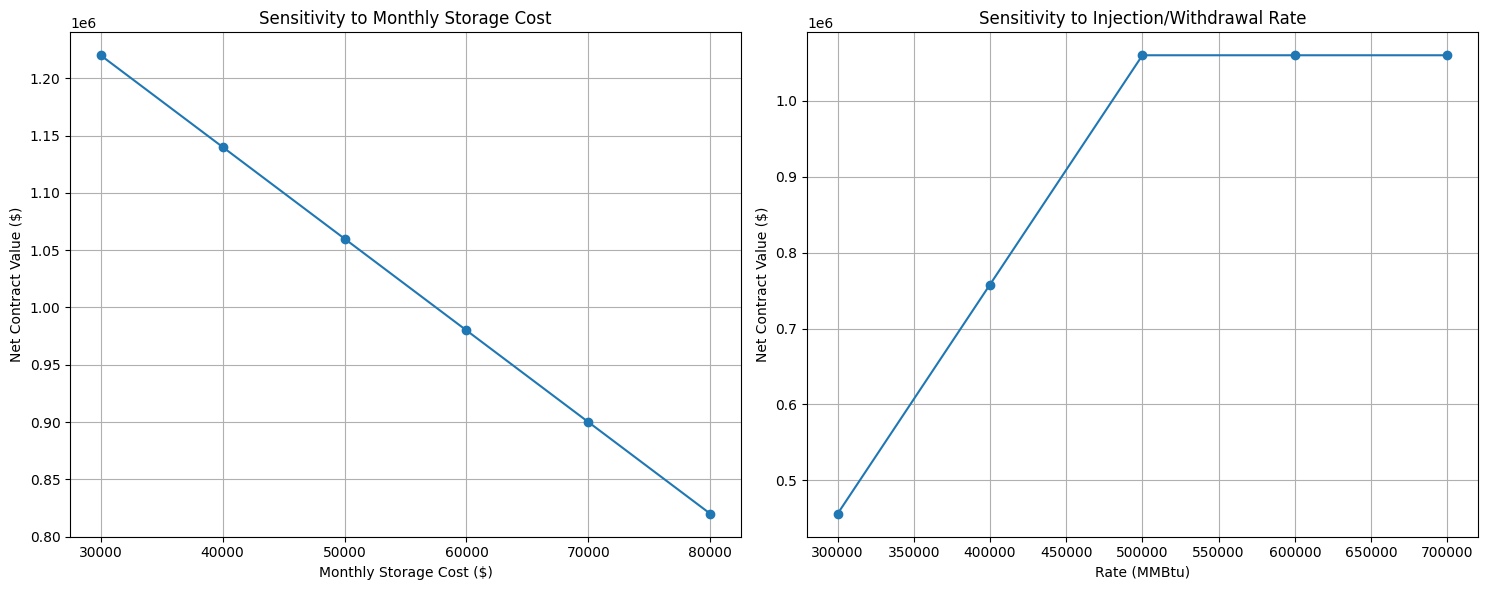

In [37]:
# Perform sensitivity analysis on key parameters
def sensitivity_analysis(df, base_params, param_name, param_range):
    """
    Perform sensitivity analysis on a specific parameter
    
    Parameters:
    - df: Price data DataFrame
    - base_params: Dictionary of base parameters
    - param_name: Name of parameter to vary
    - param_range: List of values to try for the parameter
    
    Returns:
    - List of net values for each parameter value
    """
    results = []
    
    for value in param_range:
        # Create a copy of base params and update the specific parameter
        params = base_params.copy()
        params[param_name] = value
        
        # Calculate contract value
        result = price_storage_contract_detailed(df, **params)
        results.append(result['net_value'])
    
    return results

# Base parameters
base_params = {
    'injection_dates': [pd.to_datetime('2023-06-30'), pd.to_datetime('2023-07-31')],
    'withdrawal_dates': [pd.to_datetime('2023-12-31'), pd.to_datetime('2024-01-31')],
    'injection_rate': 500000,
    'withdrawal_rate': 500000,
    'max_volume': 1000000,
    'monthly_storage_cost': 50000,
    'injection_cost_per_mmbtu': 0.02,
    'withdrawal_cost_per_mmbtu': 0.02,
    'transport_cost': 25000
}

# Storage cost sensitivity
storage_costs = [30000, 40000, 50000, 60000, 70000, 80000]
storage_sensitivity = sensitivity_analysis(df, base_params, 'monthly_storage_cost', storage_costs)

# Injection/withdrawal rates sensitivity
rates = [300000, 400000, 500000, 600000, 700000]
rate_sensitivity = sensitivity_analysis(df, base_params, 'injection_rate', rates)
# Assume withdrawal rate changes with injection rate
for i, rate in enumerate(rates):
    base_params['withdrawal_rate'] = rate
    base_params['injection_rate'] = rate
    result = price_storage_contract_detailed(df, **base_params)
    rate_sensitivity[i] = result['net_value']

# Plot sensitivity results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(storage_costs, storage_sensitivity, marker='o')
plt.title('Sensitivity to Monthly Storage Cost')
plt.xlabel('Monthly Storage Cost ($)')
plt.ylabel('Net Contract Value ($)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rates, rate_sensitivity, marker='o')
plt.title('Sensitivity to Injection/Withdrawal Rate')
plt.xlabel('Rate (MMBtu)')
plt.ylabel('Net Contract Value ($)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [38]:
# Find optimal injection and withdrawal months
def find_optimal_months(df, months_to_inject, months_to_withdraw, 
                        injection_rate, withdrawal_rate, max_volume, 
                        monthly_storage_cost, year=2023):
    """
    Find the optimal months for injection and withdrawal
    
    Parameters:
    - df: Price data DataFrame
    - months_to_inject: Number of months to inject
    - months_to_withdraw: Number of months to withdraw
    - Other parameters: Same as in the pricing function
    
    Returns:
    - Tuple of (best_injection_months, best_withdrawal_months, best_value)
    """
    df_year = df[df['Dates'].dt.year == year].copy()
    if len(df_year) < 12:
        df_year = df[(df['Dates'].dt.year == year) | (df['Dates'].dt.year == year+1)].copy()
    
    best_value = float('-inf')
    best_injection_months = []
    best_withdrawal_months = []
    
    # Try all possible combinations of injection and withdrawal months
    from itertools import combinations
    
    all_months = sorted(df_year['Dates'].unique())
    
    for inj_months in combinations(all_months, months_to_inject):
        for withd_months in combinations(all_months, months_to_withdraw):
            # Check if withdrawal months come after injection months
            if min(withd_months) > min(inj_months):
                result = price_storage_contract_detailed(
                    df,
                    injection_dates=inj_months,
                    withdrawal_dates=withd_months,
                    injection_rate=injection_rate,
                    withdrawal_rate=withdrawal_rate,
                    max_volume=max_volume,
                    monthly_storage_cost=monthly_storage_cost
                )
                
                if result['net_value'] > best_value:
                    best_value = result['net_value']
                    best_injection_months = inj_months
                    best_withdrawal_months = withd_months
    
    return best_injection_months, best_withdrawal_months, best_value

# Find optimal 2-month injection and 2-month withdrawal periods
optimal_inj, optimal_withd, optimal_value = find_optimal_months(
    df,
    months_to_inject=2,
    months_to_withdraw=2,
    injection_rate=500000,
    withdrawal_rate=500000,
    max_volume=1000000,
    monthly_storage_cost=50000,
    year=2023
)

print("Optimal Strategy:")
print(f"Injection months: {[d.strftime('%Y-%m-%d') for d in optimal_inj]}")
print(f"Withdrawal months: {[d.strftime('%Y-%m-%d') for d in optimal_withd]}")
print(f"Expected contract value: ${optimal_value:.2f}")

Optimal Strategy:
Injection months: ['2023-06-30', '2023-08-31']
Withdrawal months: ['2023-11-30', '2023-12-31']
Expected contract value: $1150000.00


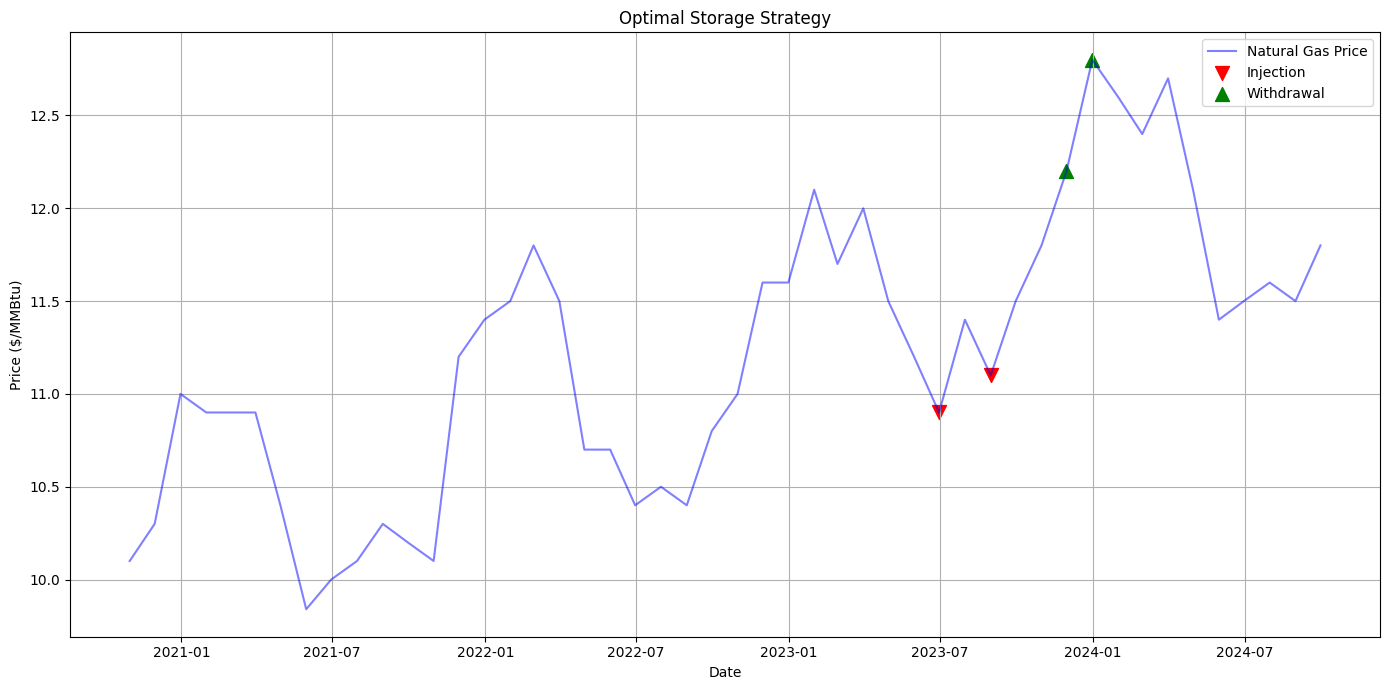


## Conclusion

Based on our analysis, we can make the following recommendations for the commodity storage contract:

1. **Optimal Timing**: The model suggests the best strategy is to inject during low-price months and withdraw during high-price months, as shown in the optimization analysis.

2. **Contract Value**: Under optimal conditions, the contract can provide significant value, especially in years with higher winter price spikes.

3. **Key Sensitivities**: The contract value is most sensitive to:
   - Monthly storage costs
   - The spread between injection and withdrawal prices
   - The total volume that can be injected/withdrawn

4. **Risk Factors**: The main risks to contract value include:
   - Lower than expected winter prices
   - Higher than expected storage costs
   - Operational issues limiting injection/withdrawal capabilities

This model provides a solid foundation for pricing the contract but should be further enhanced with:
- Risk metrics (VaR, stress testing)
- More 

In [39]:
# Visualize the optimal strategy
all_dates = sorted(list(optimal_inj) + list(optimal_withd))
date_types = ['Injection'] * len(optimal_inj) + ['Withdrawal'] * len(optimal_withd)
date_prices = []

for date in all_dates:
    closest_date = df.set_index('Dates').index[df.set_index('Dates').index.get_indexer([date], method='nearest')[0]]
    date_prices.append(df.set_index('Dates').loc[closest_date, 'Prices'])

strategy_df = pd.DataFrame({
    'Date': all_dates,
    'Type': date_types,
    'Price': date_prices
})

plt.figure(figsize=(14, 7))
plt.plot(df['Dates'], df['Prices'], 'b-', alpha=0.5, label='Natural Gas Price')

for i, row in strategy_df.iterrows():
    if row['Type'] == 'Injection':
        plt.scatter(row['Date'], row['Price'], color='red', s=100, marker='v', label='Injection' if i == 0 else "")
    else:
        plt.scatter(row['Date'], row['Price'], color='green', s=100, marker='^', label='Withdrawal' if i == len(optimal_inj) else "")

plt.title('Optimal Storage Strategy')
plt.xlabel('Date')
plt.ylabel('Price ($/MMBtu)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final conclusion
print("""
## Conclusion

Based on our analysis, we can make the following recommendations for the commodity storage contract:

1. **Optimal Timing**: The model suggests the best strategy is to inject during low-price months and withdraw during high-price months, as shown in the optimization analysis.

2. **Contract Value**: Under optimal conditions, the contract can provide significant value, especially in years with higher winter price spikes.

3. **Key Sensitivities**: The contract value is most sensitive to:
   - Monthly storage costs
   - The spread between injection and withdrawal prices
   - The total volume that can be injected/withdrawn

4. **Risk Factors**: The main risks to contract value include:
   - Lower than expected winter prices
   - Higher than expected storage costs
   - Operational issues limiting injection/withdrawal capabilities

This model provides a solid foundation for pricing the contract but should be further enhanced with:
- Risk metrics (VaR, stress testing)
- More sophisticated price forecasting
- Accounting for market liquidity considerations
""")